In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/chickweight.csv')

In [3]:
df.shape

(578, 4)

In [4]:
df.head()

,weight,Time,Chick,Diet
0,42,0,1,1
1,51,2,1,1
2,59,4,1,1
3,64,6,1,1
4,76,8,1,1


In [5]:
df.Diet.value_counts()

1    220
2    120
3    120
4    118
Name: Diet, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   weight  578 non-null    int64
 1   Time    578 non-null    int64
 2   Chick   578 non-null    int64
 3   Diet    578 non-null    int64
dtypes: int64(4)
memory usage: 18.2 KB


In [7]:
df.describe()

,weight,Time,Chick,Diet
count,578.000000,578.000000,578.000000,578.000000
mean,121.818339,10.717993,25.750865,2.235294
std,71.071960,6.758400,14.568795,1.162678
min,35.000000,0.000000,1.000000,1.000000
25%,63.000000,4.000000,13.000000,1.000000
50%,103.000000,10.000000,26.000000,2.000000
75%,163.750000,16.000000,38.000000,3.000000
max,373.000000,21.000000,50.000000,4.000000


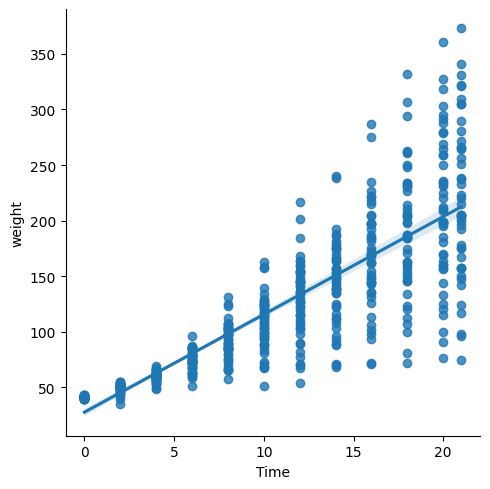

In [8]:
sns.lmplot(y='weight', x='Time', data=df);

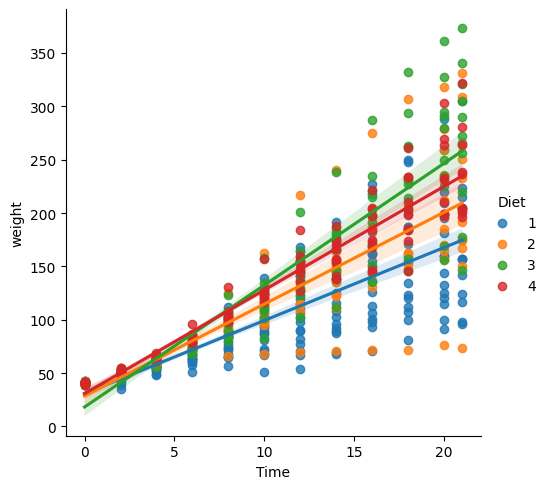

In [9]:
sns.lmplot(y='weight', x='Time', data=df, hue='Diet');

In [10]:
lm = linear_model.LinearRegression()

In [11]:
lm.fit(X=df[['Time']], y=df.weight)

LinearRegression()

In [12]:
lm.coef_

array([8.80303927])

In [13]:
lm.intercept_

27.467425149881393

In [14]:
lm.score(X=df[['Time']], y=df.weight)

0.7007392553726879

In [15]:
def build_lm_model_and_check_score(sg_df, weight_field='weight', fit_intercept=True):
    # print(f'Diet={sg_df.Diet.iloc[0]}')
    lm = linear_model.LinearRegression(fit_intercept=fit_intercept)
    lm.fit(X=sg_df[['Time']], y=sg_df[weight_field])
    # print(f'{lm.intercept_=}, {lm.coef_=}')
    return (
        sg_df.Diet.iloc[0],
        lm.intercept_,
        lm.coef_[0],
        lm.score(X=sg_df[['Time']], y=sg_df[weight_field])
    )

In [16]:
statistics = df.groupby('Diet').apply(build_lm_model_and_check_score)

In [17]:
statistics = pd.DataFrame.from_records(statistics.values, columns=['Diet', 'intercept', 'coef', 'score'])
statistics.Diet = pd.to_numeric(statistics.Diet, downcast='integer')

In [18]:
statistics

,Diet,intercept,coef,score
0,1,30.930980,6.841797,0.665409
1,2,28.633596,8.609136,0.669177
2,3,18.250325,11.422871,0.806563
3,4,30.792120,9.714366,0.906083


In [19]:
statistics.score.mean()

0.7618080621032578

In [20]:
mean_at_day_0 = df.loc[lambda d: d.Time == 0, 'weight'].mean()

In [21]:
mean_at_day_0

41.06

In [22]:
df['weight_shifted'] = df.weight - mean_at_day_0

In [23]:
assert np.allclose(df.loc[lambda d: d.Time == 0, 'weight_shifted'].mean(), 0)

In [24]:
statistics_after_shift = df.groupby('Diet').apply(
    build_lm_model_and_check_score,
    weight_field='weight_shifted',
    fit_intercept=False
)

In [25]:
statistics_after_shift = pd.DataFrame.from_records(statistics_after_shift.values, columns=['Diet', 'intercept', 'coef', 'score'])
statistics_after_shift.Diet = pd.to_numeric(statistics_after_shift.Diet, downcast='integer')

In [26]:
statistics_after_shift.score.mean()

0.7509042334938962

In [27]:
statistics

,Diet,intercept,coef,score
0,1,30.930980,6.841797,0.665409
1,2,28.633596,8.609136,0.669177
2,3,18.250325,11.422871,0.806563
3,4,30.792120,9.714366,0.906083


## Above I did not get an improvement on the score. Decided to check for heteroscedasticity.

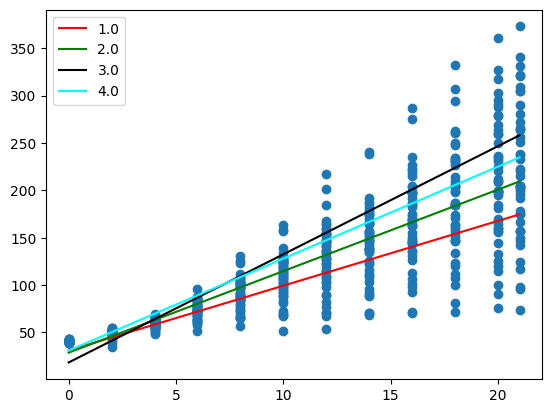

In [29]:
def plot_line(x, b, m, color, label):
    plt.plot(x, np.multiply(m, x) + b, color=color, label=label)

plt.scatter(df.Time, df.weight)
x = [0, 21]
for (i, row), color in zip(statistics.iterrows(), ['red', 'green', 'black', 'cyan']):
    plot_line(x, row['intercept'], row['coef'], color=color, label=row['Diet'])
plt.legend()
plt.show()

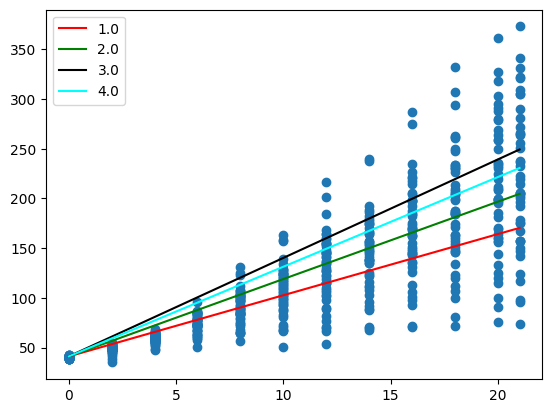

In [51]:
plt.scatter(df.Time, df.weight_shifted + mean_at_day_0)
x = [0, 21]
for (i, row), color in zip(statistics_after_shift.iterrows(), ['red', 'green', 'black', 'cyan']):
    plot_line(x, row['intercept'] + mean_at_day_0, row['coef'], color=color, label=row['Diet'])
plt.legend()
plt.show()

In [52]:
# discrepencies = (lm.predict(df.Time.to_frame()) - df.weight) ** 2

In [53]:
# discrepencies.rolling(60).mean().plot()

In [69]:
df['residual_squared'] = abs(lm.predict(df.Time.to_frame()) - df.weight) #  ** 2

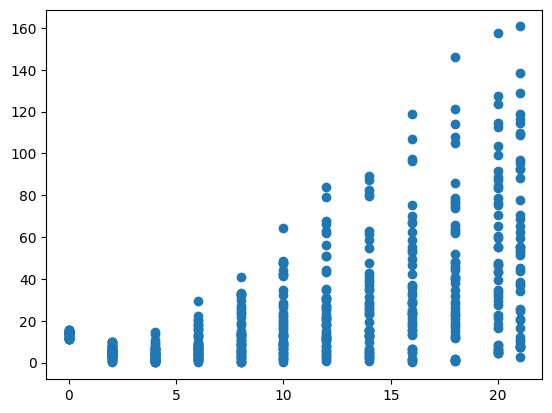

In [70]:
plt.scatter(df.Time, df.residual_squared);

In [71]:
residual_by_time = df.groupby('Time')['residual_squared'].mean()

In [72]:
residual_by_time

Time
0     13.592575
2      4.961197
4      3.964719
6      8.533500
8     13.673993
10    19.295518
12    26.610125
14    29.651247
16    36.163488
18    44.959104
20    53.500000
21    57.940694
Name: residual_squared, dtype: float64

In [73]:
new_lm = linear_model.LinearRegression()

In [74]:
new_lm.fit(df.Time.to_frame(), df.weight, 1/residual_by_time.loc[df.Time])

LinearRegression()

In [75]:
new_lm.score(df.Time.to_frame(), df.weight)

0.698371288552239